In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import boxcox
from tqdm.notebook import tqdm

In [3]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
import os
from surprise import accuracy
import numpy as np
from surprise.model_selection import RandomizedSearchCV
from surprise.model_selection import GridSearchCV


In [4]:
plt.rcParams['figure.figsize'] = (15, 8)

In [5]:
base_db = pd.read_csv("../output/base_db.csv").drop(columns="Unnamed: 0")

# Matrix factorization

In [6]:
# function to compute RMSE (needs correct matrices)
def compute_rmse(X_real, X_predict, pred_target = "score"):
    # total rmse on seen data
    dim = X_real.index.size
    s = 0
    for _, row in X_real.iterrows():
        s+=0.5*(row[pred_target] - X_predict[int(row.test_cas), int(row.species)])**2
    rmse = np.sqrt(s/dim)
    return rmse

In [7]:
def compute_absolute_intervals(X_real, X_pred_conc, pred_target="conc1_mean"):
    X_intervals = X_real.copy()
    intervals = np.zeros(X_intervals.index.size)
    prediction = np.zeros(X_intervals.index.size)
    
    for i, row in X_intervals.iterrows():
        prediction[i] =  X_pred_conc[int(row.test_cas), int(row.species)]
        intervals[i] = np.abs(row[pred_target] - prediction[i])
        
    X_intervals["prediction"] = prediction   
    X_intervals["intervals"] = intervals
    return X_intervals

# CONSIDERING ONLY 96 H

In [38]:
X_original = base_db.copy()
X_original = X_original[["test_cas", "species", "conc1_mean", "obs_duration_mean"]]

In [39]:
X_original = X_original[X_original.obs_duration_mean==96]

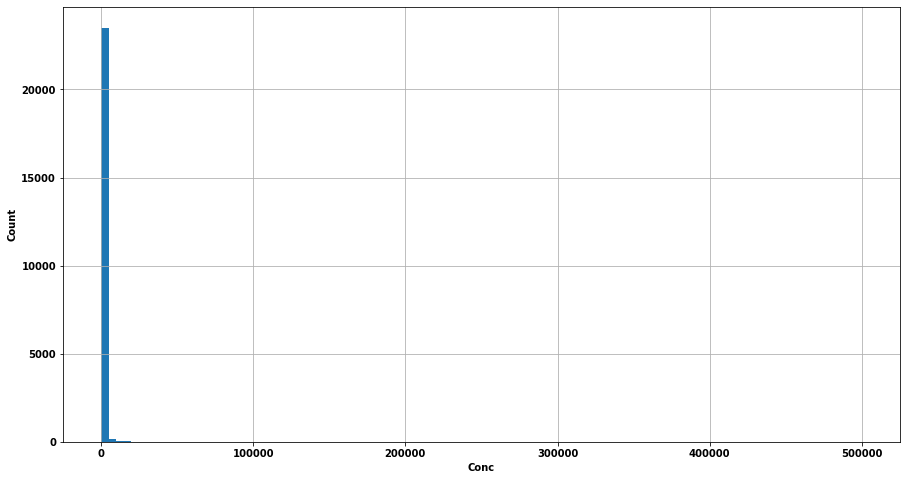

In [40]:
# plotting the distribution of conc inside this case
X_original.conc1_mean.hist(bins=100)
#plt.yscale('log')
plt.xlabel("Conc")
plt.ylabel("Count");

In [41]:
X_original = X_original.groupby(by=["test_cas", "species"]).agg("median").reset_index()

In [42]:
X_original["score"] = np.where(X_original.conc1_mean.values>1, 1, 0)

In [43]:
print("Number of positive sample", X_original[X_original.score==1].index.size)
print("Number of negative sample", X_original[X_original.score==0].index.size)

Number of positive sample 5694
Number of negative sample 3106


In [44]:
enc = OrdinalEncoder(dtype=int)
enc.fit(X_original[["test_cas", "species"]])
X_original[["test_cas", "species"]] = enc.transform(X_original[["test_cas", "species"]])
X_fact_scored = X_original.drop(columns=["conc1_mean", "obs_duration_mean"]).reset_index(drop=True)

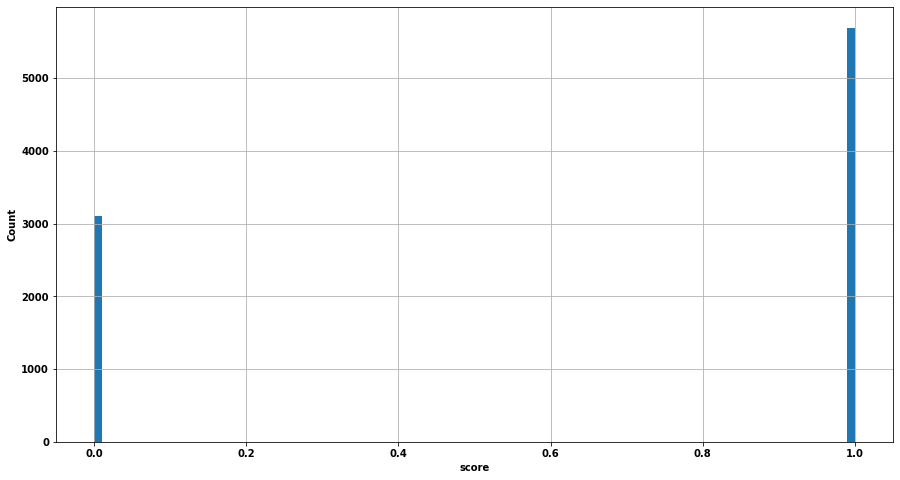

In [45]:
# plotting the distribution of conc inside this case
X_fact_scored.score.hist(bins=100)
#plt.yscale('log')
plt.xlabel("score")
plt.ylabel("Count");

In [46]:
X_train_original, X_test_original, X_train_scored, X_test_scored = train_test_split(X_original, X_fact_scored, test_size=0.33)

In [47]:
X_train_original = X_train_original.reset_index(drop=True)
X_test_original = X_test_original.reset_index(drop=True)
X_train_scored = X_train_scored.reset_index(drop=True)
X_test_scored = X_test_scored.reset_index(drop=True)

In [48]:
X_train_scored

,test_cas,species,score
0,1997,331,1
1,454,316,1
2,270,220,1
3,1654,220,1
4,405,319,1
...,...,...,...
5891,2422,220,1
5892,625,267,1
5893,847,336,0
5894,316,3,1


## First test as classifier without parameters tuning

In [91]:
fact = SVD()
cas = X_original.test_cas.max()
species = X_original.species.max()

X_train_scored.to_csv("../output/score_matrix_train_classifier.csv", header=True, index=False)

# surprise
file_path = os.path.expanduser("../output/score_matrix_train_classifier.csv")
reader = Reader(sep=",", skip_lines=1, rating_scale=(0, 1))
data = Dataset.load_from_file(file_path, reader)
#data = Dataset.load_from_df(X_train_scored, reader)


train = data.build_full_trainset()
fact.fit(train)

# predict both on train and test
X_predict_class = np.zeros((cas+1, species+1))
for d in range(0, cas+1):
    for n in range(0, species+1):
        X_predict_class[d,n] = fact.predict(str(d),str(n))[3]

In [95]:
X_predict_class = np.where(X_predict_class>=0.5, 1, 0)

In [96]:
def accuracy_sparse(X_real, X_predict):
    dim = X_real.index.size
    s = 0
    for _, row in X_real.iterrows():
        if row.score==X_predict[row.test_cas, row.species]:
            s+=1
    accuracy = s/dim
    return accuracy

In [97]:
acc_train = accuracy_sparse(X_train_scored, X_predict_class)

In [98]:
acc_train

0.8799185888738128

In [99]:
acc_test = accuracy_sparse(X_test_scored, X_predict_class)

In [100]:
acc_test

0.8023415977961432

## Implementing CV based on accuracy
- Split in 5 folds using sklearn
- Using built-in surprise CV to select best params
- Compute RMSE over test set (RMSE over transformed matrix -> dealing again with concentrations)
- Average RMSEs
- Best RMSE: save it

In [118]:
def cv_factorization(X_real_scored, lr_alls, reg_alls, n_factors, cv = 3):
    best_lr = 0
    best_reg = 0
    best_factors = 0
    best_acc = 0
    cas = X_real_scored.test_cas.max()
    species = X_real_scored.species.max()
    
    for factor in tqdm(n_factors):
        for reg in reg_alls:
            for lr in lr_alls:
            
                kf = KFold(n_splits=cv, shuffle=True)
        
                accs = []
                params = []

                for train_index, test_index in kf.split(X_real_scored):

                    X_real_scored.loc[train_index].to_csv("../output/acc_matrix_cv.csv", header=True, index=False)

                    # surprise
                    file_path = os.path.expanduser("../output/acc_matrix_cv.csv")
                    reader = Reader(sep=",", skip_lines=1, rating_scale=(0, 1))
                    data = Dataset.load_from_file(file_path, reader)
                    train = data.build_full_trainset()

                    fact = SVD(n_factors = factor, lr_all = lr, reg_all = reg)
                    fact.fit(train)

                    # accuracy
                    X_test = X_real_scored.loc[test_index].copy()
                    dim = X_test.index.size
                    s = 0
                    for _, row in X_test.iterrows():
                        pred = fact.predict(str(row.test_cas),str(row.species))[3]
                        pred = int(pred>=0.5)
                        if row.score==pred:
                            s+=1
                    acc = s/dim
                    accs.append(acc)

                avg_acc = np.mean(accs)
                
                if (avg_acc > best_acc):
                    print("New best factor found:", factor)
                    print("New best reg found:", reg)
                    print("New best lr found:", lr)
                    print("New best acc", avg_acc)
                    best_acc = avg_acc
                    best_lr = lr
                    best_reg = reg
                    best_factors = factor

    return best_acc, best_lr, best_reg, best_factors

In [120]:
factors = range(5, 61, 10)
lr_alls = np.logspace(-8, 0, 15)
reg_alls = np.logspace(-8, 0, 15)
best_acc, best_lr, best_reg, best_factors = cv_factorization(X_train_scored, lr_alls, reg_alls, factors, cv=3)

New best factor found: 5
New best reg found: 1e-08
New best lr found: 1e-08
New best acc 0.6499319646889402
New best factor found: 5
New best reg found: 1e-08
New best lr found: 5.179474679231213e-07
New best acc 0.6499336903785041
New best factor found: 5
New best reg found: 1e-08
New best lr found: 0.0003727593720314938
New best acc 0.6531548625186266
New best factor found: 5
New best reg found: 1e-08
New best lr found: 0.001389495494373136
New best acc 0.7343986877856555
New best factor found: 5
New best reg found: 1e-08
New best lr found: 0.005179474679231202
New best acc 0.7893494754335147
New best factor found: 5
New best reg found: 1e-08
New best lr found: 0.019306977288832496
New best acc 0.8176706297127504
New best factor found: 5
New best reg found: 3.7275937203149377e-08
New best lr found: 0.019306977288832496
New best acc 0.8236076920886625
New best factor found: 5
New best reg found: 1.389495494373136e-07
New best lr found: 0.019306977288832496
New best acc 0.8249653783531

## Best params up to now

In [119]:
# best_lr = 0.07196856730011514
# best_reg = 0.07196856730011514
# best_factors = 35

**Test on previous defined test set**

In [125]:
fact = SVD(n_factors=best_factors, lr_all = best_lr, reg_all = best_reg)
cas = X_original.test_cas.max()
species = X_original.species.max()

X_train_scored.to_csv("../output/score_matrix_train_classifier.csv", header=True, index=False)

# surprise
file_path = os.path.expanduser("../output/score_matrix_train_classifier.csv")
reader = Reader(sep=",", skip_lines=1, rating_scale=(0, 1))
data = Dataset.load_from_file(file_path, reader)
#data = Dataset.load_from_df(X_train_scored, reader)


train = data.build_full_trainset()
fact.fit(train)

# predict both on train and test
X_predict_class = np.zeros((cas+1, species+1))
for d in range(0, cas+1):
    for n in range(0, species+1):
        X_predict_class[d,n] = fact.predict(str(d),str(n))[3]

In [126]:
X_predict_class = np.where(X_predict_class>=0.5, 1, 0)
acc_train = accuracy_sparse(X_train_scored, X_predict_class)
print("Acc. Train:", acc_train)
acc_test = accuracy_sparse(X_test_scored, X_predict_class)
print("Acc. Test:", acc_test)

Acc. Train: 0.9581071913161465
Acc. Test: 0.8588154269972452
